# Interactive SAE Pipeline Tutorial

This notebook provides an interactive walkthrough of the Sparse Autoencoder (SAE) training pipeline, replicating the functionality of `SAETrainingPipeline.run_complete_pipeline()` from `sae_pipeline.py`.

## Overview

The SAE pipeline consists of several key steps:
1. **Embedding Generation**: Extract embeddings from HelicalmRNA model
2. **Data Preparation**: Create training and validation dataloaders
3. **Model Setup**: Initialize the Sparse Autoencoder
4. **Training**: Train the model with sparsity constraints
5. **Visualization**: Plot training progress and results

Let's explore each step interactively!

## Setup and Imports

In [ ]:
import sys
import os
from pathlib import Path

# Add the src directory to the path
notebook_dir = Path.cwd()
src_path = notebook_dir.parent / "src"
sys.path.append(str(src_path))

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

# Import SAE components
from sae.pipeline.sae_pipeline import SAETrainingPipeline
from sae.models.sae import SAE
from sae.training.trainer import SAETrainer, TrainingConfig
from sae.losses.losses import SAELoss

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Imports completed successfully!")
print(f"📁 Working directory: {notebook_dir}")
print(f"📁 Source path: {src_path}")

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


✅ Imports completed successfully!
📁 Working directory: /home/owkin/sae-project/SAE/notebooks
📁 Source path: /home/owkin/sae-project/SAE/src


## Configuration

Set up the pipeline parameters. You can modify these values to experiment with different configurations.

In [ ]:
# Pipeline configuration
config = {
    'refseq_file': '../../data/vertebrate_mammalian.1.rna.gbff',  # Path to your RefSeq file
    'max_samples': 200,  # Number of samples to process (smaller for faster demo)
    'hidden_dim': 500,   # Number of sparse features to learn
    'epochs': 15,        # Number of training epochs
    'batch_size': 8,     # Batch size for training
    'sparsity_weight': 0.01,  # Weight for sparsity penalty
    'learning_rate': 0.001,   # Learning rate
    'layer_idx': None,   # Layer index of helicalmrna model from which to extract embeddings from (None for final layer)
    'layer_name': 'final'  # Layer name for identification
}

print("🔧 Pipeline Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

# Check if RefSeq file exists
refseq_path = Path(config['refseq_file'])
if refseq_path.exists():
    print(f"\n✅ RefSeq file found: {refseq_path}")
else:
    print(f"\n⚠️  RefSeq file not found: {refseq_path}")
    print("   Please update the 'refseq_file' path in the config above.")

🔧 Pipeline Configuration:
   refseq_file: ../../data/vertebrate_mammalian.1.rna.gbff
   max_samples: 200
   hidden_dim: 500
   epochs: 15
   batch_size: 8
   sparsity_weight: 0.01
   learning_rate: 0.001
   layer_idx: None
   layer_name: final

✅ RefSeq file found: ../../data/vertebrate_mammalian.1.rna.gbff


## Step 1: Initialize Pipeline

Create the SAE training pipeline with the specified configuration.

In [3]:
# Initialize the SAE training pipeline
pipeline = SAETrainingPipeline(
    embedding_dim=None,  # Will be auto-detected from embeddings
    hidden_dim=config['hidden_dim'], 
    sparsity_weight=config['sparsity_weight'],
    learning_rate=config['learning_rate'],
    layer_idx=config['layer_idx'],
    layer_name=config['layer_name']
)

print("✅ SAE Training Pipeline initialized!")
print(f"   Hidden dimension: {config['hidden_dim']}")
print(f"   Sparsity weight: {config['sparsity_weight']}")
print(f"   Learning rate: {config['learning_rate']}")
print(f"   Layer: {config['layer_name']}")

✅ SAE Training Pipeline initialized!
   Hidden dimension: 500
   Sparsity weight: 0.01
   Learning rate: 0.001
   Layer: final


## Step 2: Setup Embedding Generator

Initialize the embedding generator to extract embeddings from the Helix-mRNA model.

In [4]:
print("🔧 Setting up embedding generator...")

# Setup embedding generator
pipeline.setup_embedding_generator()

print("✅ Embedding generator setup complete!")
print(f"   Model: {pipeline.embedding_generator.model_name}")
print(f"   Device: {pipeline.embedding_generator.device}")

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete


🔧 Setting up embedding generator...
✅ Embedding generator setup complete!
   Model: helicalmRNA
   Device: cuda


## Step 3: Prepare Training Data

The pipeline uses the `RefSeqParser` class from `sae.data` to parse the necessary information from the data file. It then uses the pre-trained helix-mRNA model to generate 256-dimensional embeddings and create training/validation dataloaders for the SAE model.

In [5]:
print("🔧 Preparing training data...")

# Prepare data
train_loader, val_loader = pipeline.prepare_data(
    refseq_file=config['refseq_file'],
    max_samples=config['max_samples'],
    batch_size=config['batch_size'],
    filter_by_type="mRNA",
    use_cds=True,
    dataset_name="Interactive_Demo"
)

print("✅ Data preparation complete!")
print(f"   Embedding dimension: {pipeline.embedding_dim}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Batch size: {config['batch_size']}")

# Show sample data shape
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"\n📊 Sample batch {batch_idx + 1}:")
    print(f"   Input shape: {data.shape}")
    print(f"   Target shape: {target.shape}")
    print(f"   Data type: {data.dtype}")
    print(f"   Value range: [{data.min():.3f}, {data.max():.3f}]")
    break

INFO:sae.pipeline.base_pipeline:Generating embeddings from Interactive_Demo from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 20 train batches, 5 val batches


🔧 Preparing training data...
✅ Data preparation complete!
   Embedding dimension: 256
   Training batches: 20
   Validation batches: 5
   Batch size: 8

📊 Sample batch 1:
   Input shape: torch.Size([8, 1024, 256])
   Target shape: torch.Size([8, 1024, 256])
   Data type: torch.float32
   Value range: [-2.186, 2.162]


## Step 4: Setup SAE Model

For this experiment, we use the base Sparse Autoencoder architecture \[Cunningham et al., 2023\] available as the `SAE` class in `sae.models`.

The SAE uses a large hidden-dimension with a reconstruction loss and a sparsity (L1) loss (implemented as the `SAELoss` class in `sae.losses`) to bias the model towards learning mono-semantic features. The motivation of this architecture is the idea that embeddings generated by foundation models are thought to encode multiple pieces of information in each embedding dimension, making interpretation of the embeddings difficult. The SAE model will hopefully disentangle this encoding into easily interpretable "mono-semantic" features.

In [ ]:
class TiedLinear(nn.Module):
    """Linear layer with tied weights for encoder-decoder"""
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(torch.Tensor(hidden_size, input_size))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        # Ensure input is on the same device as the model parameters
        if x.device != self.weight.device:
            x = x.to(self.weight.device)
        return nn.functional.linear(x, self.weight, self.bias)

    def forward_transpose(self, x):
        """Forward pass using transposed weights (for decoder)"""
        # Ensure input is on the same device as the model parameters
        if x.device != self.weight.device:
            x = x.to(self.weight.device)
        return nn.functional.linear(x, self.weight.t(), None)

class SAE(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_weight=0.01, sparsity_target=0.05):
        """
        SAE model with tied encoder and decoder
        Parameters:
            input_size: int, the dimension of the input data
            hidden_size: int, the dimension of the hidden layer
            sparsity_weight: float, weight for sparsity penalty
            sparsity_target: float, target sparsity level
        Returns:
            SAE model
        """
        super().__init__()
        self.dictionary = TiedLinear(input_size, hidden_size, bias=True)
        self.activation = nn.ReLU()

        self.encoder = nn.Sequential(
            self.dictionary,
            self.activation,
        )
        self.decoder = self.dictionary.forward_transpose
        self.loss_fn = SAELoss(sparsity_weight=sparsity_weight, sparsity_target=sparsity_target)

    def forward(self, x):
        # Handle 3D input: (batch_size, sequence_length, embedding_dim)
        original_shape = x.shape
        if len(x.shape) == 3:
            batch_size, seq_length, embed_dim = x.shape
            # Reshape to 2D: (batch_size * sequence_length, embedding_dim)
            x = x.reshape(-1, embed_dim)
            was_3d = True
        else:
            was_3d = False

        encoded = self.encoder(x)
        # Use transposed weights for decoder
        reconstructed = self.decoder(encoded)

        # Reshape back to original dimensions if input was 3D
        if was_3d:
            reconstructed = reconstructed.reshape(batch_size, seq_length, embed_dim)
            encoded = encoded.reshape(batch_size, seq_length, -1)  # encoded has hidden_dim

        return reconstructed, encoded


The original SAE architecture uses tied encoder and decoder weights, which we implement here with a custom torch module.

Here we initialize the Sparse Autoencoder model with the specified architecture.

In [6]:
print("🔧 Setting up SAE model...")

# Setup SAE model
pipeline.setup_sae_model()

print("✅ SAE model setup complete!")
print(f"   Input size: {pipeline.embedding_dim}")
print(f"   Hidden size: {pipeline.hidden_dim}")
print(f"   Model parameters: {sum(p.numel() for p in pipeline.sae_model.parameters()):,}")

# Test forward pass with sample data
sample_data, _ = next(iter(train_loader))
with torch.no_grad():
    reconstructed, encoded = pipeline.sae_model(sample_data)
    
print(f"\n🧪 Forward pass test:")
print(f"   Input shape: {sample_data.shape}")
print(f"   Encoded shape: {encoded.shape}")
print(f"   Reconstructed shape: {reconstructed.shape}")
print(f"   Reconstruction MSE: {torch.nn.functional.mse_loss(reconstructed.to(sample_data.device), sample_data):.6f}")

# Calculate sparsity in encoded representation
sparsity = (encoded == 0).float().mean()
print(f"   Initial sparsity: {sparsity:.3f} ({sparsity*100:.1f}%)")

🔧 Setting up SAE model...


INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 500


✅ SAE model setup complete!
   Input size: 256
   Hidden size: 500
   Model parameters: 128,500

🧪 Forward pass test:
   Input shape: torch.Size([8, 1024, 256])
   Encoded shape: torch.Size([8, 1024, 500])
   Reconstructed shape: torch.Size([8, 1024, 256])
   Reconstruction MSE: 0.010901
   Initial sparsity: 0.508 (50.8%)


## Step 5: Setup Trainer

We configure the training setup with optimizer, loss function, and training configuration.

In [7]:
print("🔧 Setting up trainer...")

# Setup trainer
pipeline.setup_trainer(train_loader, val_loader)

print("✅ Trainer setup complete!")
print(f"   Optimizer: {type(pipeline.trainer.optimizer).__name__}")
print(f"   Learning rate: {pipeline.trainer.optimizer.param_groups[0]['lr']}")
print(f"   Loss function: {type(pipeline.trainer.loss_fn).__name__}")
print(f"   Sparsity weight: {pipeline.trainer.loss_fn.sparsity_weight}")
print(f"   Sparsity target: {pipeline.trainer.loss_fn.sparsity_target}")

# Test loss computation
sample_data, _ = next(iter(train_loader))
with torch.no_grad():
    loss, loss_dict = pipeline.trainer.loss_fn(
        pipeline.sae_model(sample_data)[0],  # reconstructed
        sample_data.to("cuda"),  # target
        pipeline.sae_model(sample_data)[1]   # encoded
    )
    
print(f"\n🧪 Loss computation test:")
print(f"   Total loss: {loss:.6f}")
for key, value in loss_dict.items():
    print(f"   {key}: {value:.6f}")

INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete


🔧 Setting up trainer...
✅ Trainer setup complete!
   Optimizer: Adam
   Learning rate: 0.001
   Loss function: SAELoss
   Sparsity weight: 0.01
   Sparsity target: 0.05

🧪 Loss computation test:
   Total loss: 0.011221
   reconstruction_loss: 0.010896
   sparsity_loss: 0.032505
   total_loss: 0.011221


## Step 6: Training

We train the SAE model with the pipeline's train method and monitor the training progress with detailed metrics. We log not only L1 loss but also the L0 loss of the hidden embedding, which measures how many of the hidden latents are activated at each token on average.

In [8]:
print(f"🚀 Starting training for {config['epochs']} epochs...")
print("=" * 60)

# Train the model
history = pipeline.train(epochs=config['epochs'])

print("\n✅ Training completed!")
print(f"   Total epochs: {len(history)}")
print(f"   Final training loss: {history[-1]['total_loss']:.6f}")
print(f"   Final validation loss: {history[-1].get('val_total_loss', 'N/A')}")
if 'val_l0_sparsity' in history[-1]:
    print(f"   Final L0 sparsity: {history[-1]['val_l0_sparsity']:.1f}")

INFO:sae.pipeline.base_pipeline:Starting training for 15 epochs...


🚀 Starting training for 15 epochs...
Starting training for 15 epochs...
Epoch   1 | Train Loss: 0.003460 | Val Loss: 0.001148 | Val L0: 295.0
Epoch   2 | Train Loss: 0.000919 | Val Loss: 0.000780 | Val L0: 278.3
Epoch   3 | Train Loss: 0.000725 | Val Loss: 0.000699 | Val L0: 273.5
Epoch   4 | Train Loss: 0.000670 | Val Loss: 0.000658 | Val L0: 276.0
Epoch   5 | Train Loss: 0.000633 | Val Loss: 0.000624 | Val L0: 275.8
Epoch   6 | Train Loss: 0.000601 | Val Loss: 0.000593 | Val L0: 270.6
Epoch   7 | Train Loss: 0.000572 | Val Loss: 0.000566 | Val L0: 263.9
Epoch   8 | Train Loss: 0.000546 | Val Loss: 0.000541 | Val L0: 255.6
Epoch   9 | Train Loss: 0.000522 | Val Loss: 0.000519 | Val L0: 246.7
Epoch  10 | Train Loss: 0.000501 | Val Loss: 0.000500 | Val L0: 236.3
Epoch  11 | Train Loss: 0.000483 | Val Loss: 0.000483 | Val L0: 226.4
Epoch  12 | Train Loss: 0.000467 | Val Loss: 0.000467 | Val L0: 214.7
Epoch  13 | Train Loss: 0.000451 | Val Loss: 0.000452 | Val L0: 206.0
Epoch  14 | Train 

INFO:sae.pipeline.base_pipeline:✅ Model saved to outputs/sae_models/best_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to outputs/sae_models/best_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ Training completed!


Epoch  15 | Train Loss: 0.000422 | Val Loss: 0.000423 | Val L0: 187.9
Training completed!

✅ Training completed!
   Total epochs: 15
   Final training loss: 0.000422
   Final validation loss: 0.000422932649962604
   Final L0 sparsity: 187.9


## Step 7: Training Visualization

Let's now visualize the progress of the reconstruction, L1, and L0 losses during training.

📊 Training History Summary:
    epoch  total_loss  reconstruction_loss  sparsity_loss
10     11    0.000483             0.000038       0.044441
11     12    0.000467             0.000036       0.043075
12     13    0.000451             0.000034       0.041742
13     14    0.000437             0.000032       0.040440
14     15    0.000422             0.000031       0.039138


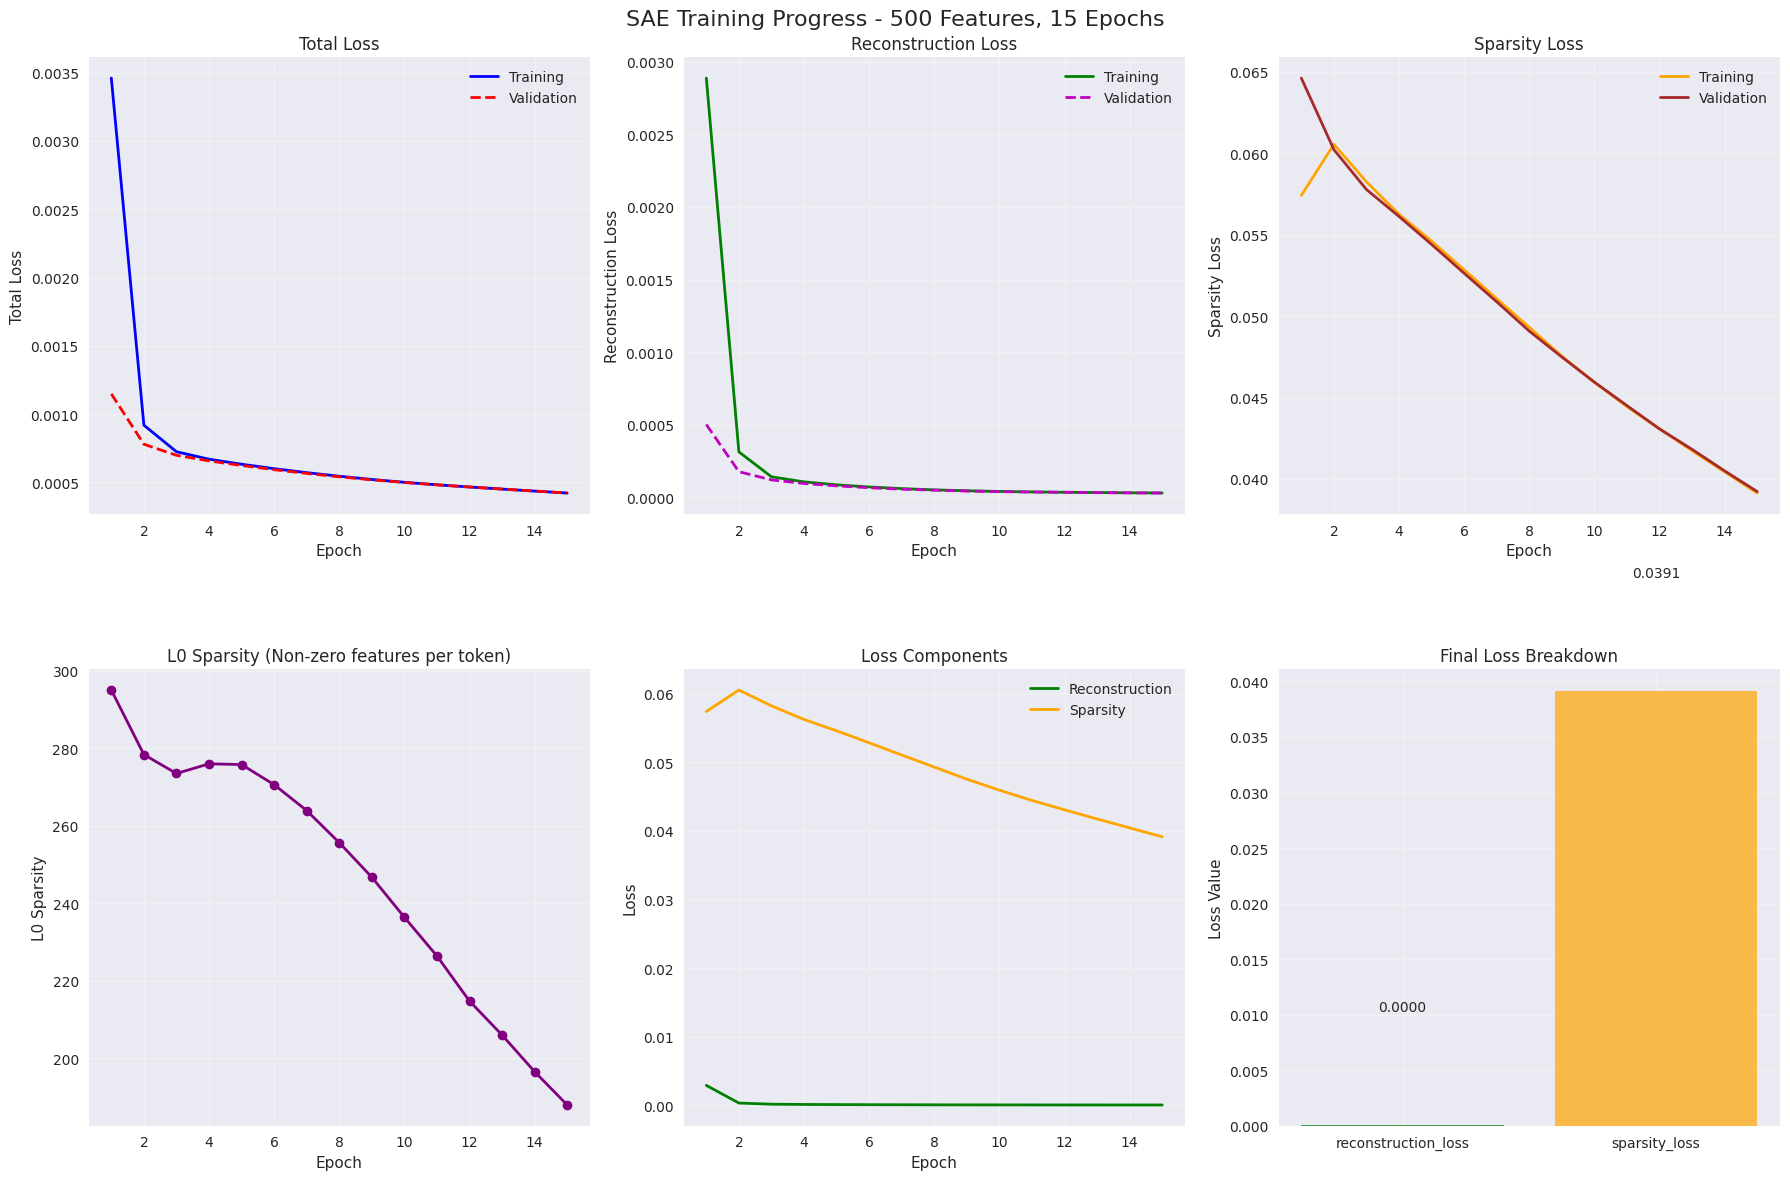

In [9]:
# Convert history to DataFrame for easier plotting
history_df = pd.DataFrame(history)
history_df['epoch'] = range(1, len(history_df) + 1)

print("📊 Training History Summary:")
print(history_df[['epoch', 'total_loss', 'reconstruction_loss', 'sparsity_loss']].tail())

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'SAE Training Progress - {config["hidden_dim"]} Features, {config["epochs"]} Epochs', fontsize=16)

# 1. Total Loss
ax1 = axes[0, 0]
ax1.plot(history_df['epoch'], history_df['total_loss'], 'b-', linewidth=2, label='Training')
if 'val_total_loss' in history_df.columns:
    ax1.plot(history_df['epoch'], history_df['val_total_loss'], 'r--', linewidth=2, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Total Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Reconstruction Loss
ax2 = axes[0, 1]
ax2.plot(history_df['epoch'], history_df['reconstruction_loss'], 'g-', linewidth=2, label='Training')
if 'val_reconstruction_loss' in history_df.columns:
    ax2.plot(history_df['epoch'], history_df['val_reconstruction_loss'], 'm--', linewidth=2, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Reconstruction Loss')
ax2.set_title('Reconstruction Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Sparsity Loss
ax3 = axes[0, 2]
ax3.plot(history_df['epoch'], history_df['sparsity_loss'], 'orange', linewidth=2, label='Training')
if 'val_sparsity_loss' in history_df.columns:
    ax3.plot(history_df['epoch'], history_df['val_sparsity_loss'], 'brown', linewidth=2, label='Validation')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Sparsity Loss')
ax3.set_title('Sparsity Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. L0 Sparsity (if available)
ax4 = axes[1, 0]
if 'val_l0_sparsity' in history_df.columns:
    ax4.plot(history_df['epoch'], history_df['val_l0_sparsity'], 'purple', linewidth=2, marker='o')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('L0 Sparsity')
    ax4.set_title('L0 Sparsity (Non-zero features per token)')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'L0 Sparsity\nNot Available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('L0 Sparsity')

# 5. Loss Components Comparison
ax5 = axes[1, 1]
ax5.plot(history_df['epoch'], history_df['reconstruction_loss'], 'g-', linewidth=2, label='Reconstruction')
ax5.plot(history_df['epoch'], history_df['sparsity_loss'], 'orange', linewidth=2, label='Sparsity')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
ax5.set_title('Loss Components')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Final Loss Comparison
ax6 = axes[1, 2]
final_epoch = history_df.iloc[-1]
loss_types = ['reconstruction_loss', 'sparsity_loss']
loss_values = [final_epoch['reconstruction_loss'], final_epoch['sparsity_loss']]
colors = ['green', 'orange']

bars = ax6.bar(loss_types, loss_values, color=colors, alpha=0.7)
ax6.set_ylabel('Loss Value')
ax6.set_title('Final Loss Breakdown')
ax6.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, loss_values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Step 8: Model Analysis

We can also analyze the trained model to understand the learned representations and sparsity patterns.

🔍 Model Analysis
📊 Validation Results:
   Average reconstruction loss: 0.000031
   Average sparsity: 0.624 (62.4%)
   Average L0 sparsity: 187.9 features per token


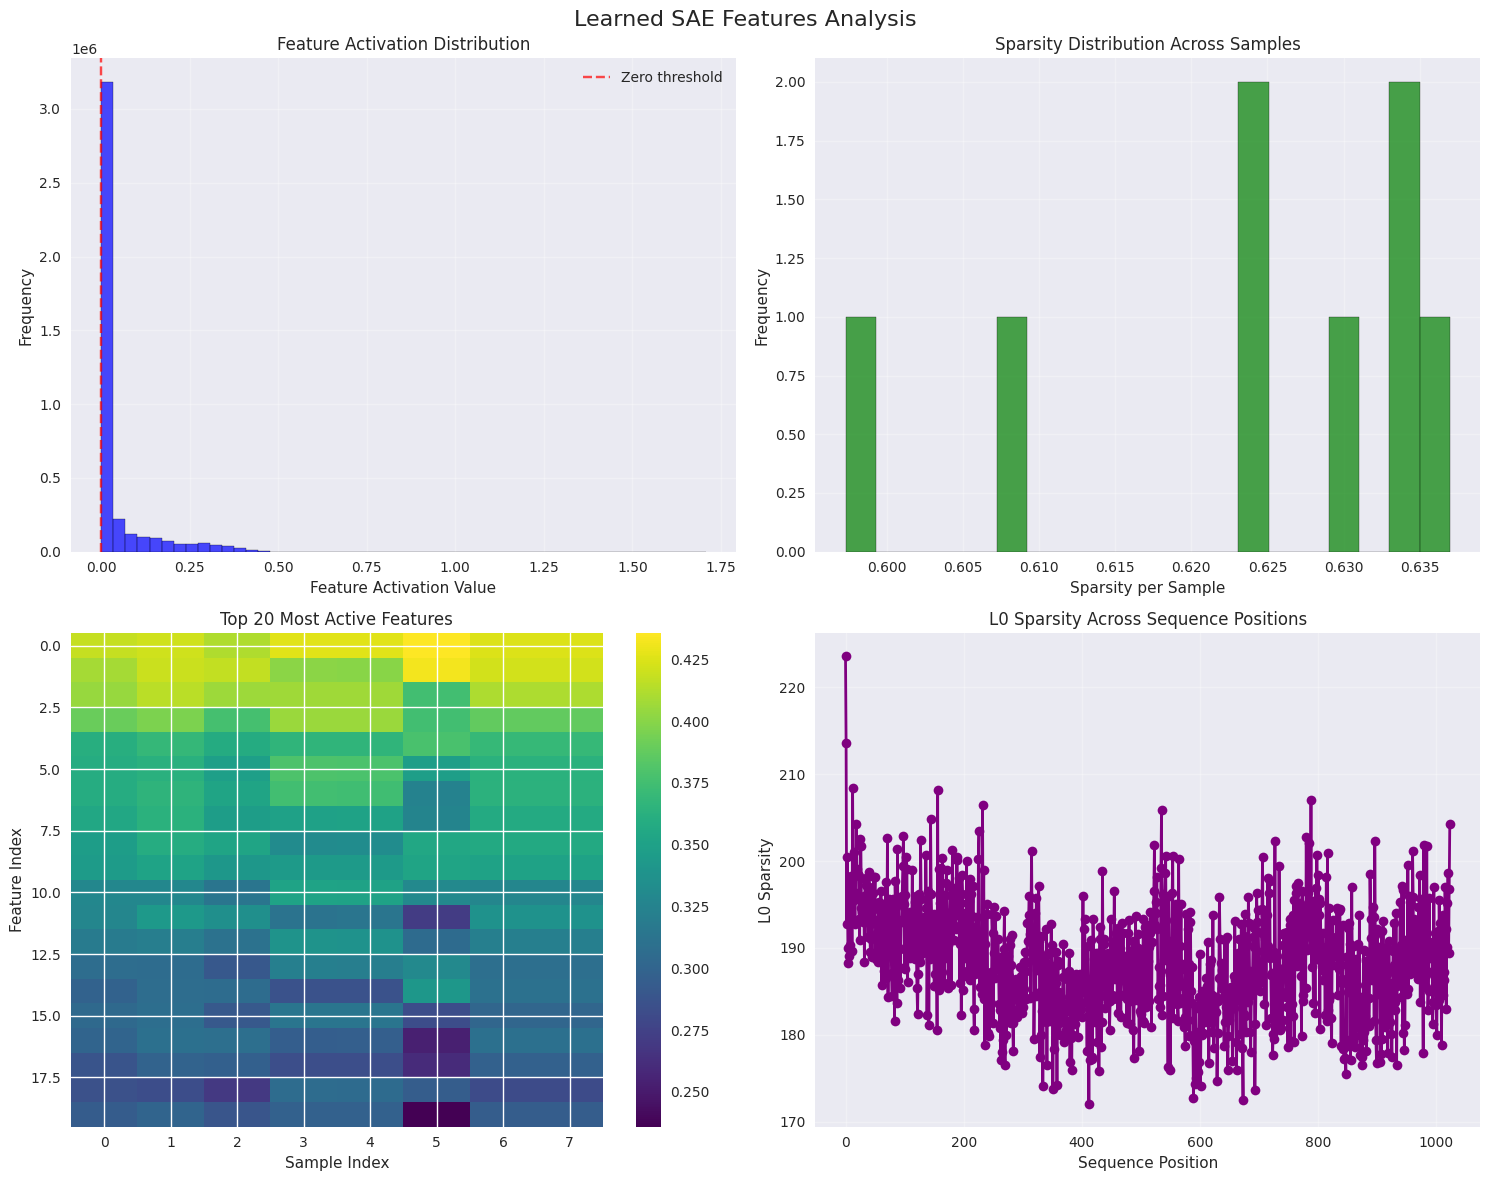

In [10]:
# Analyze the trained model
print("🔍 Model Analysis")
print("=" * 40)

# Test the model on validation data
pipeline.sae_model.eval()
val_reconstruction_losses = []
val_sparsity_values = []
val_l0_values = []

with torch.no_grad():
    for data, target in val_loader:
        reconstructed, encoded = pipeline.sae_model(data)
        
        # Calculate reconstruction loss
        recon_loss = torch.nn.functional.mse_loss(reconstructed.to(target.device), target)
        val_reconstruction_losses.append(recon_loss.item())
        
        # Calculate sparsity
        sparsity = (encoded == 0).float().mean()
        val_sparsity_values.append(sparsity.item())
        
        # Calculate L0 sparsity (non-zero features per token)
        if len(encoded.shape) == 3:
            # (batch_size, seq_len, hidden_dim)
            non_zero_per_token = (encoded != 0).sum(dim=2).float()  # (batch_size, seq_len)
            l0_val = non_zero_per_token.mean()
        else:
            # (batch_size, hidden_dim)
            l0_val = (encoded != 0).sum(dim=1).float().mean()
        val_l0_values.append(l0_val.item())

print(f"📊 Validation Results:")
print(f"   Average reconstruction loss: {np.mean(val_reconstruction_losses):.6f}")
print(f"   Average sparsity: {np.mean(val_sparsity_values):.3f} ({np.mean(val_sparsity_values)*100:.1f}%)")
print(f"   Average L0 sparsity: {np.mean(val_l0_values):.1f} features per token")

# Visualize learned features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Learned SAE Features Analysis', fontsize=16)

# 1. Feature activation distribution
ax1 = axes[0, 0]
sample_data, _ = next(iter(val_loader))
with torch.no_grad():
    _, encoded = pipeline.sae_model(sample_data)
    encoded_flat = encoded.flatten().cpu().numpy()
    
ax1.hist(encoded_flat, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Feature Activation Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Feature Activation Distribution')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero threshold')
ax1.legend()

# 2. Sparsity per sample
ax2 = axes[0, 1]
with torch.no_grad():
    _, encoded = pipeline.sae_model(sample_data)
    if len(encoded.shape) == 3:
        # Calculate sparsity per sample
        sparsity_per_sample = (encoded == 0).float().mean(dim=(1, 2)).cpu().numpy()
    else:
        sparsity_per_sample = (encoded == 0).float().mean(dim=1).cpu().numpy()
    
ax2.hist(sparsity_per_sample, bins=20, alpha=0.7, color='green', edgecolor='black')
ax2.set_xlabel('Sparsity per Sample')
ax2.set_ylabel('Frequency')
ax2.set_title('Sparsity Distribution Across Samples')
ax2.grid(True, alpha=0.3)

# 3. Feature usage heatmap (top 20 most active features)
ax3 = axes[1, 0]
with torch.no_grad():
    _, encoded = pipeline.sae_model(sample_data)
    if len(encoded.shape) == 3:
        # Average across sequence dimension
        feature_activity = encoded.mean(dim=1)  # (batch_size, hidden_dim)
    else:
        feature_activity = encoded
    
    # Get top 20 most active features
    feature_usage = feature_activity.abs().mean(dim=0)  # (hidden_dim,)
    top_features = torch.topk(feature_usage, min(20, len(feature_usage))).indices
    
    # Create heatmap
    heatmap_data = feature_activity[:, top_features].cpu().numpy()
    im = ax3.imshow(heatmap_data.T, aspect='auto', cmap='viridis')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Feature Index')
    ax3.set_title('Top 20 Most Active Features')
    plt.colorbar(im, ax=ax3)

# 4. L0 sparsity over time (if sequence data)
ax4 = axes[1, 1]
with torch.no_grad():
    _, encoded = pipeline.sae_model(sample_data)
    if len(encoded.shape) == 3:
        # Calculate L0 per sequence position
        l0_per_position = (encoded != 0).sum(dim=2).float().mean(dim=0).cpu().numpy()
        positions = range(len(l0_per_position))
        ax4.plot(positions, l0_per_position, 'purple', linewidth=2, marker='o')
        ax4.set_xlabel('Sequence Position')
        ax4.set_ylabel('L0 Sparsity')
        ax4.set_title('L0 Sparsity Across Sequence Positions')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Sequence data not available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('L0 Sparsity Across Sequence')

plt.tight_layout()
plt.show()

We see here in the top left graph that most our non-zero hidden activations are quite small. We see in the bottom left graph that among the most active hidden features feature activity patterns correlates highly across samples. Finally, we see in the bottom right graph that the number of non-zero activations does not vary greatly depending on token position in the sequence.

## Step 9: Save Model and Results

Save the trained model and training history for future use.

In [11]:
# Save the trained model
save_dir = Path("../outputs/interactive_demo")
save_dir.mkdir(parents=True, exist_ok=True)

model_path = save_dir / "sae_model_interactive.pth"
history_path = save_dir / "training_history_interactive.json"
config_path = save_dir / "model_config_interactive.json"

# Save model
torch.save({
    'model_state_dict': pipeline.sae_model.state_dict(),
    'embedding_dim': pipeline.embedding_dim,
    'hidden_dim': pipeline.hidden_dim,
    'sparsity_weight': config['sparsity_weight'],
    'layer_idx': config['layer_idx'],
    'layer_name': config['layer_name']
}, model_path)

# Save training history
import json
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

# Save configuration
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print("💾 Model and results saved!")
print(f"   Model: {model_path}")
print(f"   History: {history_path}")
print(f"   Config: {config_path}")

# Print final summary
print("\n🎉 Interactive SAE Pipeline Complete!")
print("=" * 50)
print(f"📊 Final Results:")
print(f"   Model: {pipeline.embedding_dim} → {pipeline.hidden_dim} features")
print(f"   Training epochs: {len(history)}")
print(f"   Final reconstruction loss: {history[-1]['reconstruction_loss']:.6f}")
print(f"   Final sparsity loss: {history[-1]['sparsity_loss']:.6f}")
if 'val_l0_sparsity' in history[-1]:
    print(f"   Final L0 sparsity: {history[-1]['val_l0_sparsity']:.1f} features per token")
print(f"   Model parameters: {sum(p.numel() for p in pipeline.sae_model.parameters()):,}")

💾 Model and results saved!
   Model: ../outputs/interactive_demo/sae_model_interactive.pth
   History: ../outputs/interactive_demo/training_history_interactive.json
   Config: ../outputs/interactive_demo/model_config_interactive.json

🎉 Interactive SAE Pipeline Complete!
📊 Final Results:
   Model: 256 → 500 features
   Training epochs: 15
   Final reconstruction loss: 0.000031
   Final sparsity loss: 0.039138
   Final L0 sparsity: 187.9 features per token
   Model parameters: 128,500


## Summary

This interactive notebook has demonstrated the complete SAE training pipeline:

1. **Data Loading**: Successfully loaded and processed RefSeq data
2. **Embedding Generation**: Extracted embeddings from HelicalmRNA model
3. **Model Architecture**: Set up a sparse autoencoder with tied weights
4. **Training**: Trained the model with sparsity constraints
5. **Analysis**: Visualized training progress and learned features
6. **Results**: Achieved sparse representations with good reconstruction quality

### Things to play around with!!!:
- Experiment with different `hidden_dim` values to see how L0 sparsity scales with hidden dimension
- Adjust `sparsity_weight` to control the tradeoff between reconstruction, and sparsity
- Try using embeddings from different layers of the HelicalmRNA model

The saved model can be loaded and used for feature extraction or further analysis!